In [4]:
import numpy as np
from scipy import optimize
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.special import gamma
from math import pi
#pip install fbm==0.1.0
from fbm import FBM

In [5]:
def evol_va(mu,sigma_a,fbm_sample,times,H):
    VA=np.exp( mu*times - ((sigma_a**2)/2)*(times**(2*H)) + sigma_a*fbm_sample)
    return(VA)

In [3]:
def get_H_slope(VA):
    n = VA.shape[0]
    step=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    #delta_t=step/n

    #Variance of log returns
    Var=[]
    for s in step:
        asset_value_resampled=np.array([VA[i] for i in range(0,n,s)])
        log_ret=np.diff(np.log(asset_value_resampled))
        Var.append(np.var(log_ret))

    # Régression linéaire
    fixed_intercept_log_sigma2 = np.log(Var[0]) # assuming delta = 1 otherwise H is here
    log_step = np.log(step)
    log_var_tau = np.log(Var)

    x = log_step.reshape(-1, 1)
    y = log_var_tau - fixed_intercept_log_sigma2

    model = LinearRegression(fit_intercept=False)
    model.fit(x, y)

    # Coefficients de la régression
    slope = model.coef_[0]
    H = slope / 2

    return(H)
 


In [4]:
def get_sigma_slope(VA):
    n = VA.shape[0]
    step=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    #delta_t=step/n

    #Variance of log returns
    Var=[]
    for s in step:
        asset_value_resampled=np.array([VA[i] for i in range(0,n,s)])
        log_ret=np.diff(np.log(asset_value_resampled))
        Var.append(np.var(log_ret))

    # Régression linéaire
    fixed_intercept_log_sigma2 = np.log(Var[0]) # assuming delta = 1 otherwise H is here
    log_step = np.log(step)
    log_var_tau = np.log(Var)

    # Régression linéaire
    X = log_step.reshape(-1, 1)
    y = log_var_tau
 
    model = LinearRegression()
    model.fit(X, y)
 
    # Coefficients de la régression
    intercept = model.intercept_
    slope = model.coef_[0]
 
    # Calcul de H
    H = slope / 2
    sigma_A = np.exp(intercept/2) * n**H
 
    return sigma_A



In [6]:
def get_H_from_drift(V_A, drift):
    n = V_A.shape[0]
    delta=1/n
    X = np.diff(np.log(V_A)) - drift*delta
    N = len(X)
    if N % 2 == 1:
        raise ValueError("Time series length must be even for this estimation method.")
    sum_even_odd_pairs = sum((X[2*i+1] + X[2*i])**2 for i in range(N//2 - 1))
    sum_odd_even_pairs = sum((X[2*i+2] + X[2*i+1])**2 for i in range(N//2 - 1))
    denominator = np.mean(X**2)
    H_hat = (1 / (2 * np.log(2))) * np.log( (1/(2*int(N/2))) *  (sum_even_odd_pairs + sum_odd_even_pairs) / denominator)
    return H_hat

In [7]:
def get_sigma_1(VA,H):
    n = VA.shape[0]
    step=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    #delta_t=step/n

    #Variance of log returns
    Var=[]
    for s in step:
        asset_value_resampled=np.array([VA[i] for i in range(0,n,s)])
        log_ret=np.diff(np.log(asset_value_resampled))
        Var.append(np.var(log_ret))
    var_tau = np.array(Var)

    sigma_A=[]
    for i in range (len(step)):
        sigma_A.append( np.sqrt(var_tau[i]) * ((n/step[i])**H))   
    s=np.mean(np.array(sigma_A))
    
    return(s)
    

In [8]:
def get_sigma_2(H, drift, V_A):
    N = np.shape(V_A)[0]
    delta = 1/N
    X = np.diff(np.log(V_A)) - drift*delta
    print(X)
    X_H = X**(1/H)
    print(X_H)
    sigma_hat = (np.sum(X_H))**H
    print(sigma_hat)



    return sigma_hat

In [ ]:

"""
For confidence interval
exp_sigma=np.zeros(n_it)
err_sigma=np.zeros(n_it)


for i in range (n_it):
    f = FBM(n, hurst=H, length=1, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    exp_sigma[i]=find_H(evol_va(mu,sigma_a,fbm_sample,times,H))[0]
    err_sigma[i]=(exp_sigma[i]-true_sigma)**2

return (np.mean(exp_sigma),np.mean(err_sigma))
"""

In [11]:
def H_error(sigma,mu,H,n,n_it=10, T=1):

    
    f = FBM(n, hurst=H, length=T, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    VA=evol_va(mu,sigma,fbm_sample,times,H)
    H1=get_H_slope(VA)

  
    return(H1)

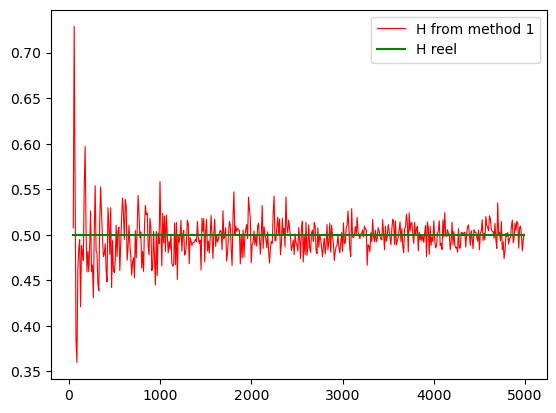

In [12]:
sigma_a=0.3
H=0.5
mu=0.1
T=1

lH1=[]
lH2=[]

liste_n=[]
r_H=[]

for n in range(50,5000,10):
    liste_n.append(n)
    H1=H_error(sigma_a,mu,H,n,n_it=10)
    lH1.append(H1)
    #lH2.append(H2)
    #err_sigma.append(e)
    r_H.append(H)

plt.plot(liste_n,lH1,label="H from method 1",linewidth=0.8,color='r')
#plt.plot(liste_n,lH2,label="H from method 2",linewidth=0.8,color="blue")
plt.plot(liste_n,r_H,label="H reel",linewidth=1.5,color="green")

plt.legend()

In [13]:
def H_error_from_drift(sigma,mu,H,n,n_it=10, T=1):

    
    f = FBM(n, hurst=H, length=T, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    VA=evol_va(mu,sigma,fbm_sample,times,H)
    
    d=get_drift(VA)
    H1=get_H_from_drift(VA,mu-((sigma**2)/2))
    Hest=get_H_from_drift(VA,d)

    return(H1,Hest)

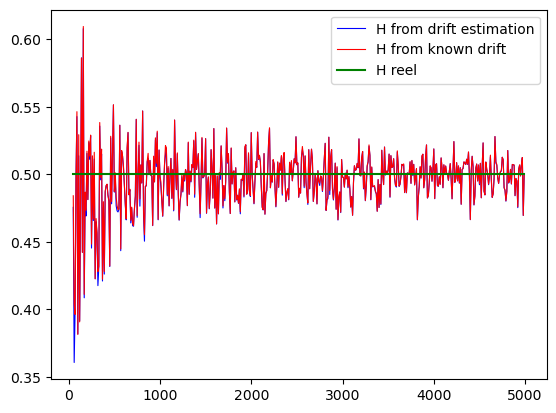

In [14]:
sigma_a=0.3
H=0.5
mu=0.1
T=1

lH1=[]
lH2=[]

liste_n=[]
r_H=[]

for n in range(50,5000,10):
    liste_n.append(n)
    H1,H2=H_error_from_drift(sigma_a,mu,H,n,n_it=10)
    lH1.append(H1)
    lH2.append(H2)
    #err_sigma.append(e)
    r_H.append(H)

plt.plot(liste_n,lH2,label="H from drift estimation",linewidth=0.8,color="blue")
plt.plot(liste_n,lH1,label="H from known drift",linewidth=0.8,color='r')
plt.plot(liste_n,r_H,label="H reel",linewidth=1.5,color="green")

plt.legend()

In [15]:
def sigma_error(true_sigma,mu,H,n,n_it=10, T=1):
     
    f = FBM(n, hurst=H, length=T, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    VA=evol_va(mu,true_sigma,fbm_sample,times,H)
    H_est=get_H_slope(VA)
    sigma_1=get_sigma_1(VA,H)
    sigma_est=get_sigma_1(VA,H_est)
    

    return(sigma_1,sigma_est)


In [16]:
def sigma_error_from_drift(true_sigma,mu,H,n,n_it=10, T=1):
     
    f = FBM(n, hurst=H, length=T, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    VA=evol_va(mu,true_sigma,fbm_sample,times,H)

    sigma_1=get_sigma_2(H,mu-((true_sigma**2)/2),VA)

    drift_est=get_drift(VA)
    H_est=get_H_from_drift(VA,drift_est)
    sigma_est=get_sigma_2(H_est,drift_est,VA)

    return(sigma_1,sigma_est)


In [17]:
def sigma_error_intercept(true_sigma,mu,H,n,n_it=10, T=1):
     
    f = FBM(n, hurst=H, length=T, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    VA=evol_va(mu,true_sigma,fbm_sample,times,H)

    sigma_1=get_sigma_slope(VA)

    return(sigma_1)

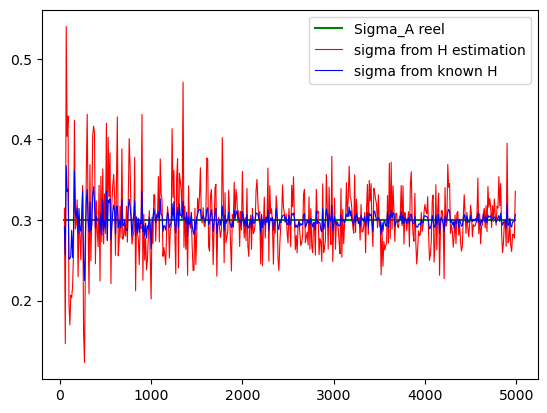

In [18]:
sigma_a=0.3
H=0.5
mu=0
T=1

sigma_1=[]
sigma_est=[]
sigma_3=[]
sigma_4=[]
liste_n=[]
r_s=[]

for n in range(50,5000,10):
    liste_n.append(n)
    s1,sest=sigma_error(sigma_a,mu,H,n,n_it=10)
    sigma_1.append(s1)
    sigma_est.append(sest)
    #sigma_3.append(s3)
    #sigma_4.append(s4)
    r_s.append(sigma_a)


#plt.plot(liste_n,sigma_1,label="sigma from method 1",linewidth=0.8,color='r')
plt.plot(liste_n,r_s,label="Sigma_A reel",linewidth=1.5,color="green")
plt.plot(liste_n,sigma_est,label="sigma from H estimation",linewidth=0.8,color="red")
plt.plot(liste_n,sigma_1,label="sigma from known H",linewidth=0.8,color="blue")
#plt.plot(liste_n,sigma_4,label="sigma from known H",linewidth=0.8,color="red")
plt.legend()

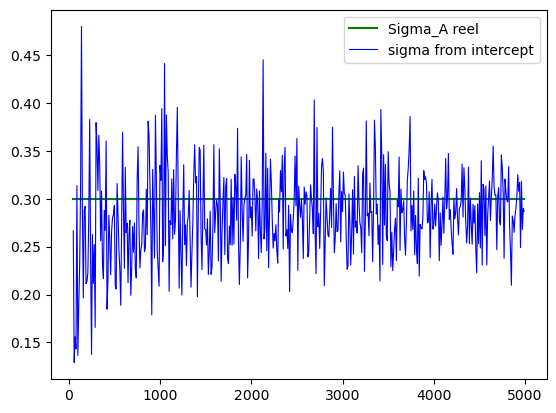

In [19]:
sigma_a=0.3
H=0.7
mu=0
T=1

sigma_1=[]
liste_n=[]
r_s=[]

for n in range(50,5000,10):
    liste_n.append(n)
    s1=sigma_error_intercept(sigma_a,mu,H,n,n_it=10)
    sigma_1.append(s1)
    r_s.append(sigma_a)

plt.plot(liste_n,r_s,label="Sigma_A reel",linewidth=1.5,color="green")
plt.plot(liste_n,sigma_1,label="sigma from intercept",linewidth=0.8,color="blue")
plt.legend()

100
300
500
700
900
1100
1300
1500
1700
1900
2100
2300
2500


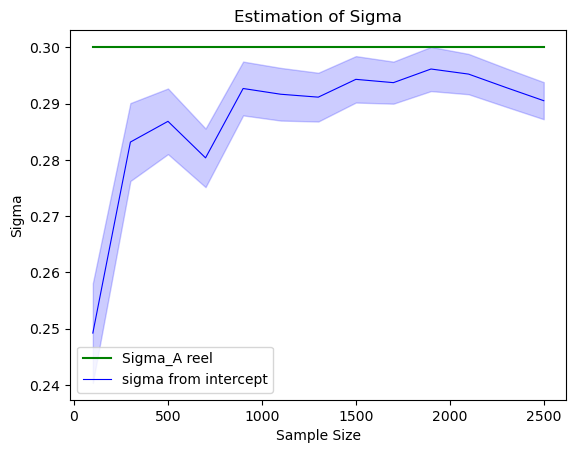

In [35]:
sigma_a=0.3
H=0.6
mu=0
T=1

sigma_1=[]
ci=[]

liste_n=[]
r_s=[]
N=500

for n in range(100,2700,200):
    print(n)
    liste_n.append(n)
    all_sig=[]
    for j in range(N):
        s1=sigma_error_intercept(sigma_a,mu,H,n,n_it=10)
        all_sig.append(s1)
    all_sig=np.array(all_sig)
    m=np.mean(all_sig)
    std=np.std(all_sig)
    
    ci.append(1.96*std/np.sqrt(N) )
    sigma_1.append(m)
    r_s.append(sigma_a)

sigma_1=np.array(sigma_1)
ci=np.array(ci)
fig, ax = plt.subplots()
ax.plot(liste_n,r_s,label="Sigma_A reel",linewidth=1.5,color="green")
ax.plot(liste_n,sigma_1,label="sigma from intercept",linewidth=0.8,color="blue")
ax.fill_between(liste_n, (sigma_1-ci), (sigma_1+ci), color='b', alpha=.2)
plt.title('Estimation of Sigma')
plt.xlabel('Sample Size')
plt.ylabel('Sigma')

plt.legend()

100
300
500
700
900
1100
1300
1500
1700
1900
2100
2300
2500


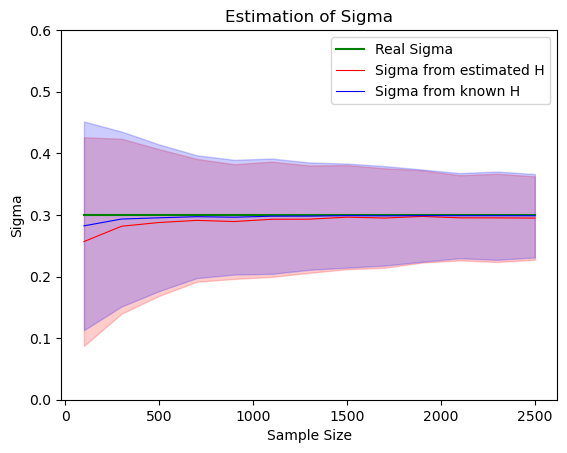

In [47]:
sigma_a=0.3
H=0.6
mu=0
T=1

sigma_1=[]
sigma_2=[]
ci=[]
ci2=[]

liste_n=[]
r_s=[]
N=500

for n in range(100,2700,200):
    print(n)
    liste_n.append(n)
    all_sig1=[]
    all_sig2=[]

    for j in range(N):
        s1,s2=sigma_error(sigma_a,mu,H,n,n_it=10)
        all_sig1.append(s1)
        all_sig2.append(s2)

    all_sig1=np.array(all_sig1)
    all_sig2=np.array(all_sig2)

    m1=np.mean(all_sig1)
    std1=np.std(all_sig1)
    ci.append(1.96*std1 )
    sigma_1.append(m1)
    
    m2=np.mean(all_sig2)
    std2=np.std(all_sig2)
    ci2.append(1.96*std2 )
    sigma_2.append(m2)
    
    r_s.append(sigma_a)

sigma_1=np.array(sigma_1)
sigma_2=np.array(sigma_2)
ci=np.array(ci)
ci=np.array(ci2)

fig, ax = plt.subplots()
ax.plot(liste_n,r_s,label="Real Sigma",linewidth=1.5,color="green")
ax.plot(liste_n,sigma_2,label="Sigma from estimated H",linewidth=0.8,color="red")
ax.fill_between(liste_n, (sigma_2-ci), (sigma_2+ci), color='r', alpha=.2)
ax.plot(liste_n,sigma_1,label="Sigma from known H",linewidth=0.8,color="blue")
ax.fill_between(liste_n, (sigma_1-ci), (sigma_1+ci), color='b', alpha=.2)


plt.title('Estimation of Sigma')
plt.xlabel('Sample Size')
plt.ylabel('Sigma')
plt.ylim(0,0.6)

plt.legend()
plt.savefig('sigma_estimation.png')

100
300
500
700
900
1100
1300
1500
1700
1900
2100
2300
2500


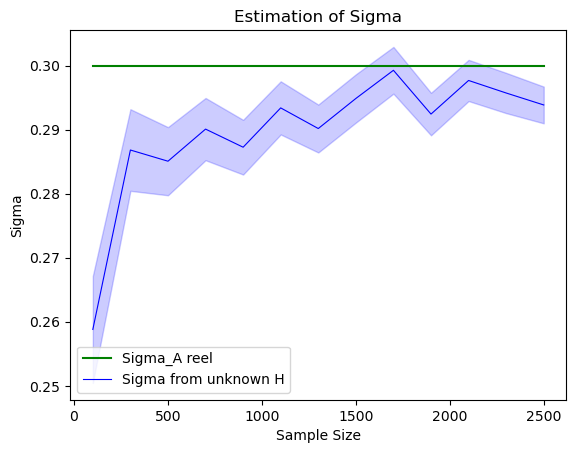

In [33]:
sigma_a=0.3
H=0.6
mu=0
T=1

sigma_1=[]
ci=[]

liste_n=[]
r_s=[]
N=500

for n in range(100,2700,200):
    print(n)
    liste_n.append(n)
    all_sig=[]
    for j in range(N):
        s1=sigma_error(sigma_a,mu,H,n,n_it=10)[1]
        all_sig.append(s1)
    all_sig=np.array(all_sig)
    m=np.mean(all_sig)
    std=np.std(all_sig)
    
    ci.append(1.96*std/np.sqrt(N) )
    sigma_1.append(m)
    r_s.append(sigma_a)

sigma_1=np.array(sigma_1)
ci=np.array(ci)
fig, ax = plt.subplots()
ax.plot(liste_n,r_s,label="Sigma_A reel",linewidth=1.5,color="green")
ax.plot(liste_n,sigma_1,label="Sigma from unknown H",linewidth=0.8,color="blue")
ax.fill_between(liste_n, (sigma_1-ci), (sigma_1+ci), color='b', alpha=.2)
plt.title('Estimation of Sigma')
plt.xlabel('Sample Size')
plt.ylabel('Sigma')

plt.legend()

100
300
500
700
900
1100
1300
1500
1700
1900
2100
2300
2500


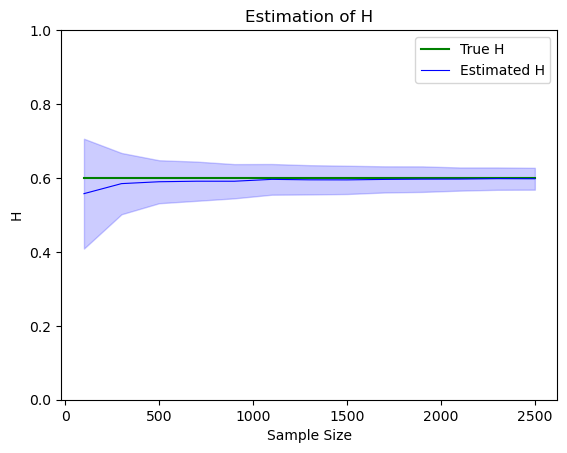

In [41]:
sigma_a=0.3
H=0.6
mu=0
T=1

lH1=[]
ci=[]

liste_n=[]
r_s=[]
N=500

for n in range(100,2700,200):
    print(n)
    liste_n.append(n)
    all_H=[]
    for j in range(N):
        H1=H_error(sigma_a,mu,H,n,n_it=10)
        all_H.append(H1)
    all_H=np.array(all_H)
    m=np.mean(all_H)
    std=np.std(all_H)
    
    ci.append(std*1.96)
    lH1.append(m)
    r_s.append(H)

lH1=np.array(lH1)
ci=np.array(ci)
fig, ax = plt.subplots()
ax.plot(liste_n,r_s,label="True H",linewidth=1.5,color="green")
ax.plot(liste_n,lH1,label="Estimated H",linewidth=0.8,color="blue")
ax.fill_between(liste_n, (lH1-ci), (lH1+ci), color='b', alpha=.2)
plt.title('Estimation of H')
plt.xlabel('Sample Size')
plt.ylabel('H')
plt.ylim(0,1)
plt.legend()
plt.savefig('H_estimation.png')



100


(array([  1.,   4.,  20.,  32.,  64., 113., 114.,  99.,  44.,   9.]),
 array([0.26846081, 0.31686665, 0.3652725 , 0.41367834, 0.46208419,
        0.51049003, 0.55889588, 0.60730173, 0.65570757, 0.70411342,
        0.75251926]),
 <BarContainer object of 10 artists>)

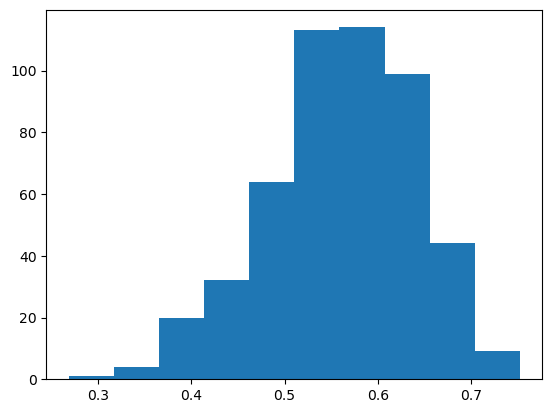

In [39]:
sigma_a=0.3
H=0.6
mu=0
T=1

lH1=[]
ci=[]

liste_n=[]
r_s=[]
N=500

for n in range(100,200,200):
    print(n)
    liste_n.append(n)
    all_H=[]
    for j in range(N):
        H1=H_error(sigma_a,mu,H,n,n_it=10)
        all_H.append(H1)
    all_H=np.array(all_H)
    m=np.mean(all_H)
    std=np.std(all_H)
    
    ci.append(1.96*std/np.sqrt(N) )
    lH1.append(m)
    r_s.append(H)
plt.hist(all_H)

500


(array([ 3.,  1.,  5., 14., 13., 22., 18., 12.,  8.,  4.]),
 array([0.11620396, 0.14592667, 0.17564937, 0.20537207, 0.23509477,
        0.26481748, 0.29454018, 0.32426288, 0.35398558, 0.38370829,
        0.41343099]),
 <BarContainer object of 10 artists>)

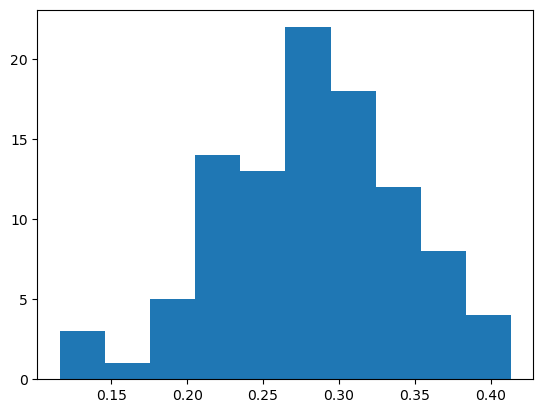

In [28]:
sigma_a=0.3
H=0.6
mu=0
T=1

sigma_1=[]
ci=[]

liste_n=[]
r_s=[]
N=100

for n in range(500,600,200):
    print(n)
    liste_n.append(n)
    all_sig=[]
    for j in range(N):
        s1=sigma_error_intercept(sigma_a,mu,H,n,n_it=10)
        #print(s1)
        all_sig.append(s1)
    all_sig=np.array(all_sig)
    m=np.mean(all_sig)
    std=np.std(all_sig)
    
    ci.append(1.96*std/np.sqrt(N) )
    sigma_1.append(s1)
    r_s.append(sigma_a)

plt.hist(all_sig)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


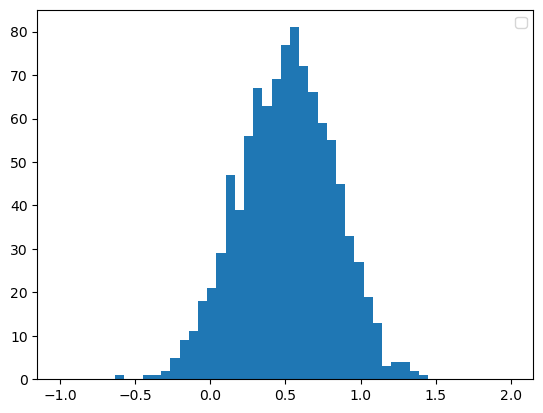

In [47]:
sigma_a=0.3
H=0.6
mu=0.5
T=1
n=500

N=1000

#l1=np.zeros(N)
l2=np.zeros(N)

for k in range(N):
    liste_n.append(n)
    mu1,mu2=mu_error(sigma_a,mu,H,n,n_it=10)
    #l1[k]=mu1
    l2[k]=mu2


    #err_sigma.append(e)

plt.hist(l2,bins=np.linspace(-1,2,50))

plt.legend()

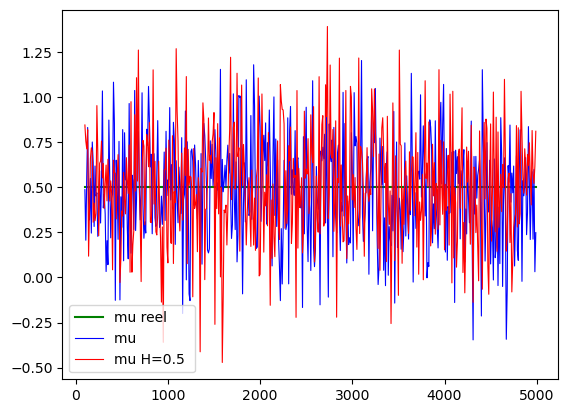

In [16]:

sigma_a=0.3
H=0.6
mu=0.5
T=1
n=500

#N=1000


mu_1=[]
mu_05=[]
liste_n=[]
r_s=[]

for n in range(100,5000,10):
    liste_n.append(n)
    mu1,mu2=mu_error(sigma_a,mu,H,n,n_it=10)
    mu_1.append(mu1)
    mu1,mu2=mu_error(sigma_a,mu,0.5,n,n_it=10)
    mu_05.append(mu1)
    r_s.append(mu)

mutest=[mu+]
plt.plot(liste_n,r_s,label="mu reel",linewidth=1.5,color="green")
plt.plot(liste_n,mu_1,label="mu ",linewidth=0.8,color="blue")
plt.plot(liste_n,mu_05,label="mu H=0.5 ",linewidth=0.8,color="red")

plt.legend()

In [9]:
def get_drift(VA):
    n = VA.shape[0]
    step=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    delta_t=[s/252 for s in step]

    Y=np.log(np.array([VA[i] for i in range(0,n)]))
    Z=np.diff(Y)
    drift=(1/n)*(1/delta_t[0])*np.sum(Z)
    return(drift)

In [10]:
def get_mu(VA,sigma):
    drift=get_drift(VA)
    mu=drift+((sigma**2)/2)
    return(mu)

In [12]:
def get_mu2(VA,H,sigma_A):
     
    n = VA.shape[0]
    step=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    #delta_t=step/n

    asset_value_resampled=np.array([VA[i] for i in range(0,n)])
    log_ret=np.diff(np.log(asset_value_resampled))
    Mean=np.mean(log_ret)

    delta=1/252
    t=1

    mu = (Mean + ((sigma_A ** 2) / (2 * t)) * ((t + delta) ** (2 * H + 1) - t ** (2 * H + 1) - delta ** (2 * H + 1)) / (2 * H + 1)) / delta

    
    return(mu)
           


In [22]:
def get_mu3(VA,H,sigma_A):
    n=VA.shape[0]
    delta=1/252
    T=n*delta
    
    return(
    (1/T)*np.log(VA[n-1]/VA[0]) + ((sigma_A**2)/2)*T**(2*H-1)
    )

In [20]:
def mu_error(sigma,mu,H,n,n_it=10, T=1):
    
    f = FBM(n, hurst=H, length=T*n/252, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    VA=evol_va(mu,sigma,fbm_sample,times,H)
    #mu1=find_H_sigma(VA)[2]
    mu1=get_mu(VA,sigma)
    mu2=get_mu3(VA,H,sigma)

    return(mu1,mu2)

100
300
500
700
900
1100
1300
1500
1700
1900
2100
2300
2500


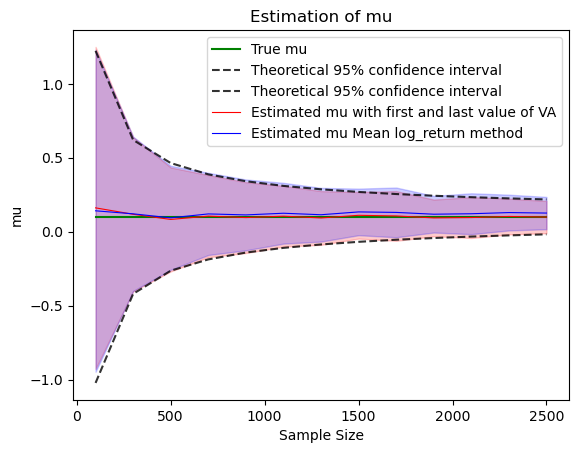

In [33]:
sigma_a=0.3
H=0.3
mu=0.1
T=1

mu_v=[]
ci=[]
mu_v2=[]
ci2=[]

liste_n=[]
r_s=[]
rtest=[]
N=200

for n in range(100,2700,200):
    print(n)
    liste_n.append(n)
    all_mu=[]
    all_mu2=[]
    for j in range(N):
        mu1,mu2=mu_error(sigma_a,mu,H,n,n_it=10)
        #l1[k]=mu1
        all_mu.append(mu1)
        all_mu2.append(mu2)

    all_mu=np.array(all_mu)
    all_mu2=np.array(all_mu2)

    m=np.mean(all_mu)
    m2=np.mean(all_mu2)
    std=np.std(all_mu)
    std2=np.std(all_mu2)
    
    ci.append(std*1.96)
    ci2.append(std2*1.96)
    mu_v.append(m)
    mu_v2.append(m2)

    r_s.append(mu)
    rtest.append(1.96*sigma_a*(T*n/252)**(H-1))

r_s=np.array(r_s)
rtest=np.array(rtest)

mu_v=np.array(mu_v)
ci=np.array(ci)
mu_v2=np.array(mu_v2)
ci2=np.array(ci2)
fig, ax = plt.subplots()
ax.plot(liste_n,r_s,label="True mu",linewidth=1.5,color="green")
ax.plot(liste_n,r_s+rtest,'--',label="Theoretical 95% confidence interval",linewidth=1.5,color="black",alpha=0.8)
ax.plot(liste_n,r_s-rtest,'--',label="Theoretical 95% confidence interval",linewidth=1.5,color="black",alpha=0.8)


ax.plot(liste_n,mu_v2,label="Estimated mu with first and last value of VA",linewidth=0.8,color="red")
ax.fill_between(liste_n, (mu_v2-ci2), (mu_v2+ci2), color='r', alpha=.2)
ax.plot(liste_n,mu_v,label="Estimated mu Mean log_return method",linewidth=0.8,color="blue")
ax.fill_between(liste_n, (mu_v-ci), (mu_v+ci), color='b', alpha=.2)

plt.title('Estimation of mu')
plt.xlabel('Sample Size')
plt.ylabel('mu')
plt.legend()
plt.savefig('mu_estimation.png')

In [1]:
def get_mu_merton(VA,sigma):
    n = VA.shape[0]
    #delta=1/n
    delta=1/252

    tau=np.diff(np.log(VA))
    return(
        np.mean(tau)/delta + (sigma**2)/2
    )

In [7]:
def mu_merton_error(sigma,mu,n,n_it=10, T=1):
    
    f = FBM(n, hurst=0.5, length=T*n/252, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    VA=evol_va(mu,sigma,fbm_sample,times,0.5)
    mu=get_mu_merton(VA,sigma)
    return(mu)

100
300
500
700
900
1100
1300
1500
1700
1900
2100
2300
2500


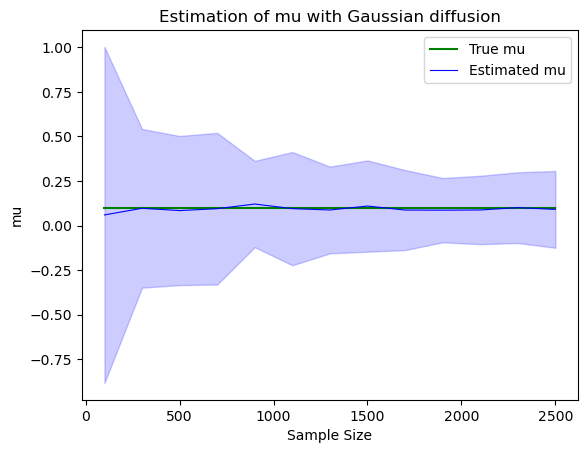

In [8]:
sigma_a=0.3
H=0.6
mu=0.1
T=1

mu_v=[]
ci=[]

liste_n=[]
r_s=[]
N=50

for n in range(100,2700,200):
    print(n)
    liste_n.append(n)
    all_mu=[]
    for j in range(N):
        mu1=mu_merton_error(sigma_a,mu,n,n_it=10)
        #l1[k]=mu1
        all_mu.append(mu1)
    all_mu=np.array(all_mu)
    m=np.mean(all_mu)
    std=np.std(all_mu)
    
    ci.append(std*1.96)
    mu_v.append(m)
    r_s.append(mu)

mu_v=np.array(mu_v)
ci=np.array(ci)
fig, ax = plt.subplots()
ax.plot(liste_n,r_s,label="True mu",linewidth=1.5,color="green")
ax.plot(liste_n,mu_v,label="Estimated mu from ",linewidth=0.8,color="blue")
ax.fill_between(liste_n, (mu_v-ci), (mu_v+ci), color='b', alpha=.2)
plt.title('Estimation of mu with Gaussian diffusion')
plt.xlabel('Sample Size')
plt.ylabel('mu')
plt.legend()
